In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [2]:
ticker         = params.ticker
look_back      = params.look_back_tick
features_cols  = params.features_cols
label_col      = params.label_col

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

df_raw = pd.read_csv(params.ready_csv, index_col=0, parse_dates=True)
df = models.feature_engineering(df_raw, features_cols, label_col)
df.to_csv(params.final_csv)
df

Using device: cuda


,open,high,low,close,atr_14,vwap_dev,bb_width_20,ma_5,ma_20,macd_12_26,obv,in_trading,hour,bid,ask,signal_smooth
2014-04-03 10:49:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.131792
2014-04-03 10:50:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.132326
2014-04-03 10:51:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.132862
2014-04-03 10:52:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.133399
2014-04-03 10:53:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.133939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,0.304529,1.249034e+00,0.014819,173.91300,174.838390,-0.422065,3.294477e+08,1,20,173.512900,173.617100,0.001063
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,0.317029,1.246621e+00,0.016242,173.73700,174.736890,-0.466939,3.288235e+08,1,20,173.328000,173.432000,0.005465
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,0.323814,1.245701e+00,0.017430,173.53500,174.634390,-0.502359,3.283690e+08,1,20,173.258000,173.362000,0.007152
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,0.322743,1.245284e+00,0.018221,173.38100,174.527890,-0.526778,3.272742e+08,1,20,173.228000,173.332000,0.007898


In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# Build LSTM input tensors (disk-backed memmaps)
#    Returns five tensors on `device`:
#      X        : (N, look_back, F)
#      y        : (N,)
#      raw_close: (N,)
#      raw_bid  : (N,)
#      raw_ask  : (N,)
# ──────────────────────────────────────────────────────────────────────────────
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df             = df,
    look_back      = look_back,
    features_cols  = params.features_cols,
    label_col      = params.label_col,
    regular_start  = params.regular_start_pred
)

print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

Shapes:
  X         = torch.Size([1441001, 120, 13]) (samples, look_back, features)
  y         = torch.Size([1441001]) (samples,)
  raw_close = torch.Size([1441001])
  raw_bid   = torch.Size([1441001])
  raw_ask   = torch.Size([1441001])


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
#    (We use the helper `chronological_split` that returns)
#      (X_tr, y_tr),
#      (X_val, y_val),
#      (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te)
# ──────────────────────────────────────────────────────────────────────────────
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back       = look_back,
    regular_start   = params.regular_start_pred,
    train_prop      = params.train_prop,
    val_prop        = params.val_prop,
    train_batch     = params.hparams['TRAIN_BATCH']
)

print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([1013805, 120, 13])
  y_tr        = torch.Size([1013805])
  raw_close_te= torch.Size([215642])
  raw_bid_te  = torch.Size([215642])
  raw_ask_te  = torch.Size([215642])


In [5]:
# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"\nBaseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1013805, val=211554, te=215642
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready

Baseline (zero‐forecast) RMSE on validation = 0.466070


In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────
def objective_train(trial):

    hp = {
        # ── Architecture ────────────────────────────────────────────────
        "DROPOUT_SHORT": trial.suggest_float(
            "DROPOUT_SHORT", 0.10, 0.23
        ),
    
        "DROPOUT_LONG": trial.suggest_float(
            "DROPOUT_LONG", 0.26, 0.35
        ),
    
        "ATT_DROPOUT": trial.suggest_float(
            "ATT_DROPOUT", 0.15, 0.20
        ),
    
    
        # ── Optimizer & Scheduler ──────────────────────────────────────
        "INITIAL_LR": trial.suggest_float(
            "INITIAL_LR", 5e-4, 9e-4
        ),
    
        "ETA_MIN": trial.suggest_float(
            "ETA_MIN", 1.5e-5, 3e-5
        ),
    
        "WEIGHT_DECAY": trial.suggest_float(
            "WEIGHT_DECAY", 1e-5, 4.5e-5
        ),
    
        "CLIPNORM": trial.suggest_float(
            "CLIPNORM", 0.5, 1.5
        ),
    }
       
    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    # Build model
    model = models.DualMemoryLSTM(
        n_feats       = len(params.features_cols),
        short_units   = params.hparams["SHORT_UNITS"],
        long_units    = params.hparams["LONG_UNITS"],
        dropout_short = hp["DROPOUT_SHORT"],
        dropout_long  = hp["DROPOUT_LONG"],
        att_drop      = hp["ATT_DROPOUT"],
    ).to(device)

    # Build optimizer + schedulers + scaler
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )

    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )

    # Run training & return best validation RMSE
    best_rmse = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams["MAX_EPOCHS"],
        early_stop_patience = params.hparams["EARLY_STOP_PATIENCE"],
        baseline_val_rmse   = baseline_val_rmse,
        clipnorm            = clipnorm,
        device              = device,
    )

    del model
    del optimizer
    del plateau_sched
    del cosine_sched
    del scaler

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_rmse



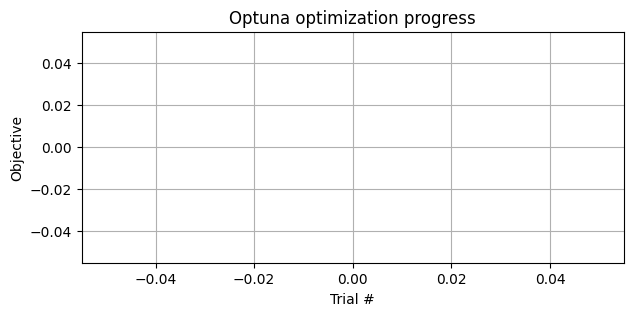

In [8]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-08-02 18:06:42,551] A new study created in RDB with name: no-name-7a672e8d-7703-490c-9f79-a2fae6bfeeec



▶ Trial 0 starting with:
{'DROPOUT_SHORT': 0.17151233366891544, 'DROPOUT_LONG': 0.27793685952412794, 'ATT_DROPOUT': 0.16115368689282744, 'INITIAL_LR': 0.0007744271867512914, 'ETA_MIN': 2.1258487775827046e-05, 'WEIGHT_DECAY': 4.046234293896237e-05, 'CLIPNORM': 0.9534587055862479}



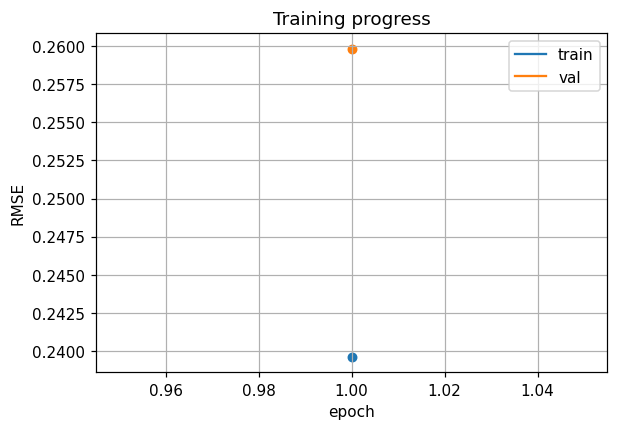

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2396 • val=0.2598 • lr=7.74e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

[W 2025-08-02 18:07:39,396] Trial 0 failed with parameters: {'DROPOUT_SHORT': 0.17151233366891544, 'DROPOUT_LONG': 0.27793685952412794, 'ATT_DROPOUT': 0.16115368689282744, 'INITIAL_LR': 0.0007744271867512914, 'ETA_MIN': 2.1258487775827046e-05, 'WEIGHT_DECAY': 4.046234293896237e-05, 'CLIPNORM': 0.9534587055862479} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_77932/1919493117.py", line 68, in objective_train
    best_rmse = models.custom_stateful_training_loop(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py", line 894, in custom_stateful_training_loop
    train_losses.append(loss.item())
                        ^^^^^^^^^^^
KeyboardInterrupt
[W 2025-08-02 18:07:39,424] Trial 0 failed 

KeyboardInterrupt: 

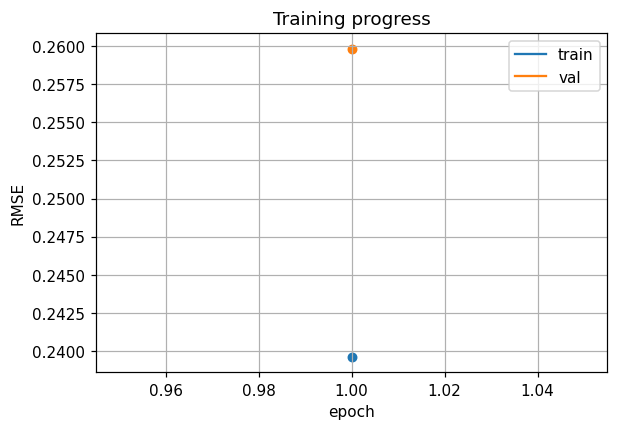

In [9]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

def cleanup_cb(study, trial):
    # Python‐side
    gc.collect()
    # CUDA‐side (no‐op on CPU only)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
study.optimize(
    objective_train,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, cleanup_cb],
)

# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
